In [3]:
!pip install --quiet sbibm
!pip install --quiet chainconsumer==0.34.0!git clone https://github.com/LSSTDESC/sbi_bm_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
fatal: destination path 'sbi_bm_lens' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [4]:
import csv
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
from sbibm.visualisation.metric import fig_metric

In [ ]:
COLOR_MAP = [
    '#f8c471',
    '#d68910',
    '#cd6155',
    '#edbb99',
    '#5d6d7e',
    '#73c6b6',
    '#a3b899'
]

# Convergence plot results with gradients

exp_nle_70000_100_1_4_2_silu_affine_128_0.0_unmarginal_0.0
exp_nle_70000_100_6_4_2_silu_affine_128_0.0_unmarginal_0.0


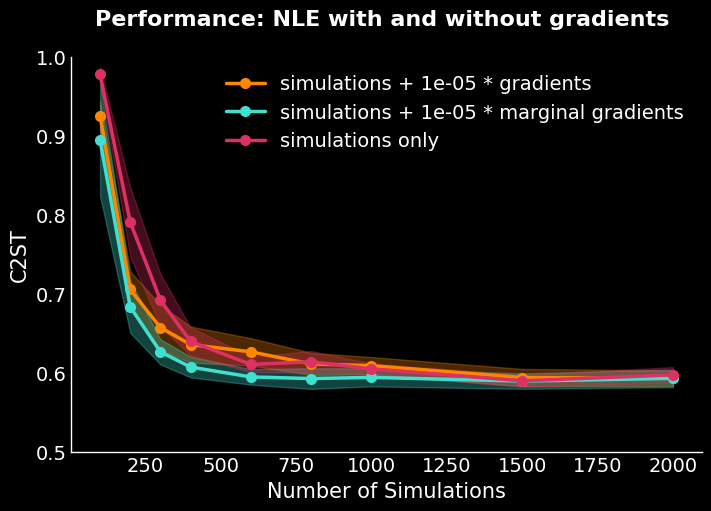

In [ ]:

az.style.use("arviz-white")
plt.style.use("dark_background")
# az.style.use("arviz-darkgrid")
# plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams['lines.markersize'] = 7

# colmap = ['#FD5F00', '#8AD5E6']
# colmap=['#D68910', '#CD6155', '#5D6D7E']

colmap = [
    '#FF8700',
    '#40E0D0',
    '#DE3163'
]

table = pd.read_table("/content/sbi_bm_lens/results/results_bm_grad.csv", sep=',')

total_steps = 70_000
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
proposal = 'prior'
sbi_method  = 'nle'
lr_schedule = 'exp_decay'
nf = 'affine'
bacth_size = 128


info_setup = [
    ['unmarginal', 0.0, 1e-05],
    ['marginal', 0.0, 1e-05],
    ['unmarginal', 0.0, 0.0]
]

legend = [
    'simulations + 1e-05 * gradients',
    'simulations + 1e-05 * marginal gradients',
    'simulations only'
]

metric_mean = {}
metric_std = {}
sim = {}
for info in info_setup:

    score, score_noise, score_weight = info

    store_metric_mean = []
    store_metric_std = []
    store_sim = []

    for nb_simulations_allow in [100,200,300,400,600,800,1000,1500,2000]:
        c2st_store = []
        for seed in [1,2,3,4,5,6,111]:

            exp_id = "exp_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                sbi_method,
                total_steps,
                nb_simulations_allow,
                seed,
                n_flow_layers,
                n_bijector_layers,
                activ_fun,
                nf,
                bacth_size,
                score_weight,
                score,
                score_noise,
            )

            new_table = table.loc[
                  (table['experiment_id'] == exp_id)
            ]

            if len(new_table["c2st"]) != 0:
                c2st = list(new_table["c2st"])[0]
                c2st_store.append(c2st)
            else:
                print(exp_id)

        store_metric_mean.append(jnp.mean(jnp.array(c2st_store)))
        store_metric_std.append(jnp.std(jnp.array(c2st_store)))
        store_sim.append(nb_simulations_allow)

        metric_mean['score_type:{}_score_noise:{}_score_weight:{}'.format(score, score_noise, score_weight)] = store_metric_mean
        metric_std['score_type:{}_score_noise:{}_score_weight:{}'.format(score, score_noise, score_weight)] = store_metric_std
        sim['score_type:{}_score_noise:{}_score_weight:{}'.format(score, score_noise, score_weight)] = store_sim


plt.figure(figsize=(7,5))


for i, info in enumerate(info_setup):

    score, score_noise, score_weight = info
    mean_y = jnp.array(metric_mean['score_type:{}_score_noise:{}_score_weight:{}'.format(score, score_noise, score_weight)])
    std_y = jnp.array(metric_std['score_type:{}_score_noise:{}_score_weight:{}'.format(score, score_noise, score_weight)])
    axex = jnp.array(sim['score_type:{}_score_noise:{}_score_weight:{}'.format(score, score_noise, score_weight)])


    plt.plot(
        axex,
        mean_y,
        label = legend[i],
        marker = 'o',
        c = colmap[i]
    )
    plt.fill_between(axex, mean_y + 0.8 * std_y, mean_y - 0.8 * std_y, alpha = 0.3, color = colmap[i])

plt.ylim([0.5,1])
# plt.xscale('log')
plt.xlabel('Number of Simulations')
plt.ylabel('C2ST')
plt.legend()

plt.title('Performance: NLE with and without gradients \n', fontweight='bold')
plt.savefig('NLE_grad_bm.png', transparent=True)

# Convergence plot results Benchmark

In [ ]:
table = pd.read_table("/content/sbi_bm_lens/results/results_bm_sbi.csv", sep=',')

info_setup = [
    ['fmpe', None, ' fmpe'],
    ['snle', 1, ' nle'],
    ['snle', 5, ' snle'],
    ['snre', 1, ' nre'],
    ['snre', 5, ' snre'],
    ['snpe', 1, ' npe'],
    ['snpe', 5, ' snpe'],
]

num_sim = [200, 500, 1000, 1500, 2000]


for i, info in enumerate(info_setup):

    sbi_method, nb_round, algo = info

    if sbi_method == 'fmpe':
      table_tmp = table.loc[(
        (table['sbi_method']==sbi_method)
      )]

    else:
      table_tmp = table.loc[(
          (table['sbi_method']==sbi_method) &
          (table['nb_round']==nb_round)
      )]

    new_table = table_tmp.loc[table_tmp['nb_simulations'].isin(num_sim)]
    new_table = new_table[['nb_simulations', 'c2st']]
    new_table = new_table.rename(columns = {'nb_simulations':'num_simulations', 'c2st':'C2ST'})
    new_table.insert(0, "algorithm", [algo] * len(new_table), True)

    if i==0:
        store_table = new_table
    else:
        store_table = pd.concat([new_table, store_table])

In [ ]:
store_table

,algorithm,num_simulations,C2ST
0,snpe,200,0.83440
9,snpe,500,0.63295
12,snpe,500,0.65610
13,snpe,1000,0.63260
15,snpe,500,0.63255
...,...,...,...
155,fmpe,2000,0.74500
156,fmpe,1500,0.74460
157,fmpe,1500,0.75030
158,fmpe,2000,0.74640


In [ ]:
chart = fig_metric(
    store_table,
    'C2ST',
    title='Benchmark Algorithms Performance',
    colors_dict = {
        'fmpe':'#f8c471',
        'nle':'#d68910',
        'npe':'#cd6155',
        'nre':'#edbb99',
        'snle':'#5d6d7e',
        'snpe':'#73c6b6',
        'snre':'#a3b899'
    }
    # config='manuscript'
)

In [ ]:
chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)